In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier  
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import csv

In [7]:
#loading data
file_1="/workspaces/State-of-Health-Estimation-Battery/Dataset/B0005_dis_dataset.csv"
dataset=pd.read_csv(file_1)

C_max=2

#renaming columns for simplicity
dataset.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset["current_load"]= abs(dataset["current_load"])

#removing ideling / starting and ending current level data  
df=dataset[(dataset.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df["time"]=df["time"]/3600

#calculate Soc for each cycle
cycle_count=df["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df[df['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df["Soc"] = [(q / C_max) for q in Soc_list]
df["Soh"]=df["capacity"]/C_max

df= df.astype(pd.Int64Dtype())

# selecting parameters 
att_=["cycle","capacity","voltage","current","temperature","current_load","voltage_load","time","Soc"]
att=["cycle","current_load","voltage_load","Soc","time"]
X_axis="cycle"

X = df[att]
Y = df[["Soh"]]

TypeError: cannot safely cast non-equivalent object to int64

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0) 

In [4]:
#sorting data wrt to index
X_test = X_test.sort_index(axis=0)
X_train= X_train.sort_index(axis=0)
y_train= y_train.sort_index(axis=0)
y_test = y_test.sort_index(axis=0)

In [5]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [9]:
def graph_plot(a,model):
    plt.plot(X_test["cycle"],y_test,color='red',label='actual',linewidth=4)
    plt.plot(X_test["cycle"],a,color='cyan',label='dis_tree'+model,linewidth=1)
    plt.xlabel("cycle")
    plt.ylabel("SOH")
    rmse="Rmse = "+str(np.sqrt(metrics.mean_squared_error(y_test, a)))
    plt.figtext(0.33, -0.03, rmse, fontsize=10)
    plt.legend(loc="upper right")
    plt.suptitle("Decision Tree")
    plt.show()
    print(np.sqrt(metrics.mean_squared_error(y_test, a)))

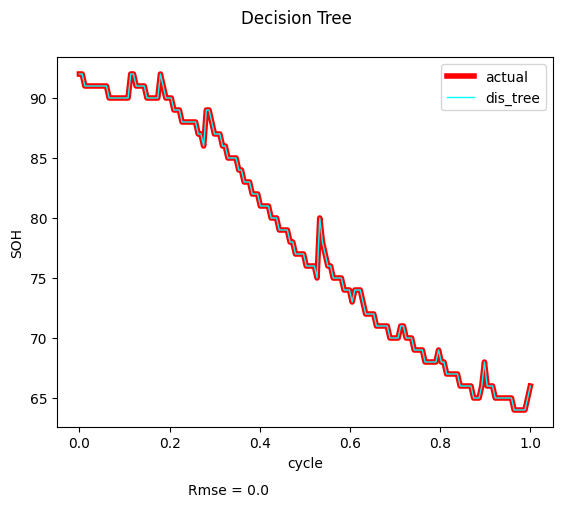

0.0


In [10]:
graph_plot(y_pred,"")